# Radial Laplacian Eigenvalue Asymptotic Analysis (ℓ=0)

Testing asymptotic behavior of eigenvalues for all boundary conditions.

For large n, eigenvalues k_n (where λ_n = k_n²) should approach:
- **Case A (0,R)**: regularity-Dirichlet: k_n → nπ/R, regularity-Neumann: k_n → nπ/R
- **Case B (a,b)**: DD: k_n = nπ/L (exact), DN/ND/NN: k_n → nπ/L

In [1]:
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval import Lebesgue
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.radial_operators import RadialLaplacian
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Case A: Domain (0, R) - Regularity-Dirichlet

#Asymptotic: k_n → nπ/R for large n

INFO:pygeoinf.interval.radial_operators:RadialLaplacian initialized: method=spectral, dofs=20, ℓ=0, alpha=0.1
/tmp/ipykernel_21842/1112673496.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()
/tmp/ipykernel_21842/1112673496.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


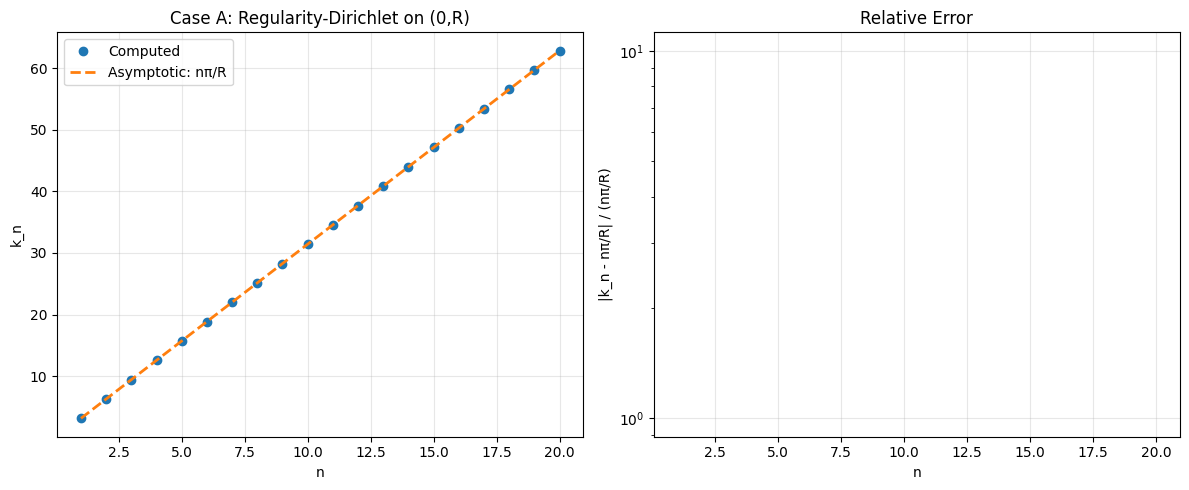

Max relative error: 0.00e+00
Relative error for n=20: 0.00e+00


In [3]:
R = 1.0
alpha = 0.1
eps = 1e-6

domain_A = IntervalDomain(0, R, boundary_type='left-open')
M_A = Lebesgue(100, domain_A, basis=None, weight=lambda r: (r + eps)**2)
bcs_reg_dir = BoundaryConditions.dirichlet()
L_reg_dir = RadialLaplacian(M_A, bcs_reg_dir, alpha, method='spectral', dofs=20, ell=0)

# Compute eigenvalues
n_eigs = 20
eigenvalues = [L_reg_dir.get_eigenvalue(i) for i in range(n_eigs)]
k_n = np.sqrt(np.array(eigenvalues) / alpha)

# Asymptotic formula
n = np.arange(1, n_eigs + 1)
k_asymptotic = n * np.pi / R

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: k_n vs n
ax1.plot(n, k_n, 'o', label='Computed', markersize=6)
ax1.plot(n, k_asymptotic, '--', label='Asymptotic: nπ/R', linewidth=2)
ax1.set_xlabel('n')
ax1.set_ylabel('k_n')
ax1.set_title('Case A: Regularity-Dirichlet on (0,R)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative error
rel_error = np.abs(k_n - k_asymptotic) / k_asymptotic
ax2.semilogy(n, rel_error, 'o-', markersize=6)
ax2.set_xlabel('n')
ax2.set_ylabel('|k_n - nπ/R| / (nπ/R)')
ax2.set_title('Relative Error')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max relative error: {rel_error.max():.2e}")
print(f"Relative error for n=20: {rel_error[-1]:.2e}")

## Case A: Domain (0, R) - Regularity-Neumann

Asymptotic: k_n → nπ/R for large n

INFO:pygeoinf.interval.radial_operators:RadialLaplacian initialized: method=spectral, dofs=20, ℓ=0, alpha=0.1


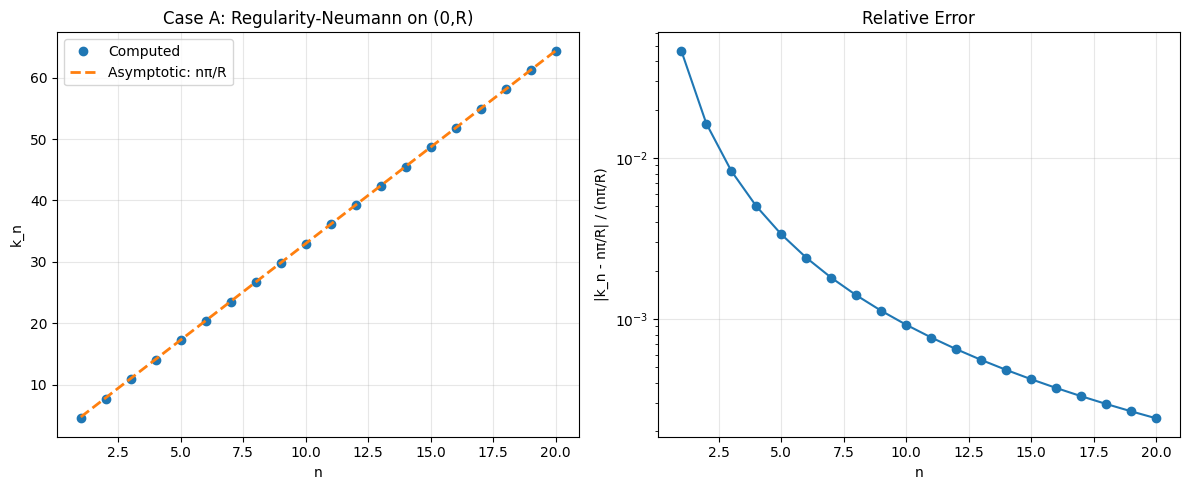

Max relative error: 4.65e-02
Relative error for n=20: 2.41e-04


In [4]:
R = 1.0
alpha = 0.1
eps = 1e-6

domain_A = IntervalDomain(0, R, boundary_type='left-open')
M_A = Lebesgue(100, domain_A, basis=None, weight=lambda r: (r + eps)**2)
bcs_reg_neu = BoundaryConditions.neumann()
L_reg_neu = RadialLaplacian(M_A, bcs_reg_neu, alpha, method='spectral', dofs=20, ell=0)

# Compute eigenvalues
n_eigs = 20
eigenvalues = [L_reg_neu.get_eigenvalue(i) for i in range(n_eigs)]
k_n = np.sqrt(np.array(eigenvalues) / alpha)

# Asymptotic formula
n = np.arange(1, n_eigs + 1)
k_asymptotic = (n+1/2) * np.pi / R

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: k_n vs n
ax1.plot(n, k_n, 'o', label='Computed', markersize=6)
ax1.plot(n, k_asymptotic, '--', label='Asymptotic: nπ/R', linewidth=2)
ax1.set_xlabel('n')
ax1.set_ylabel('k_n')
ax1.set_title('Case A: Regularity-Neumann on (0,R)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative error
rel_error = np.abs(k_n - k_asymptotic) / k_asymptotic
ax2.semilogy(n, rel_error, 'o-', markersize=6)
ax2.set_xlabel('n')
ax2.set_ylabel('|k_n - nπ/R| / (nπ/R)')
ax2.set_title('Relative Error')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max relative error: {rel_error.max():.2e}")
print(f"Relative error for n=20: {rel_error[-1]:.2e}")

## Case B: Domain (a, b) - Dirichlet-Dirichlet

Exact: k_n = nπ/L (should have zero error)

INFO:pygeoinf.interval.radial_operators:RadialLaplacian initialized: method=spectral, dofs=20, ℓ=0, alpha=0.1


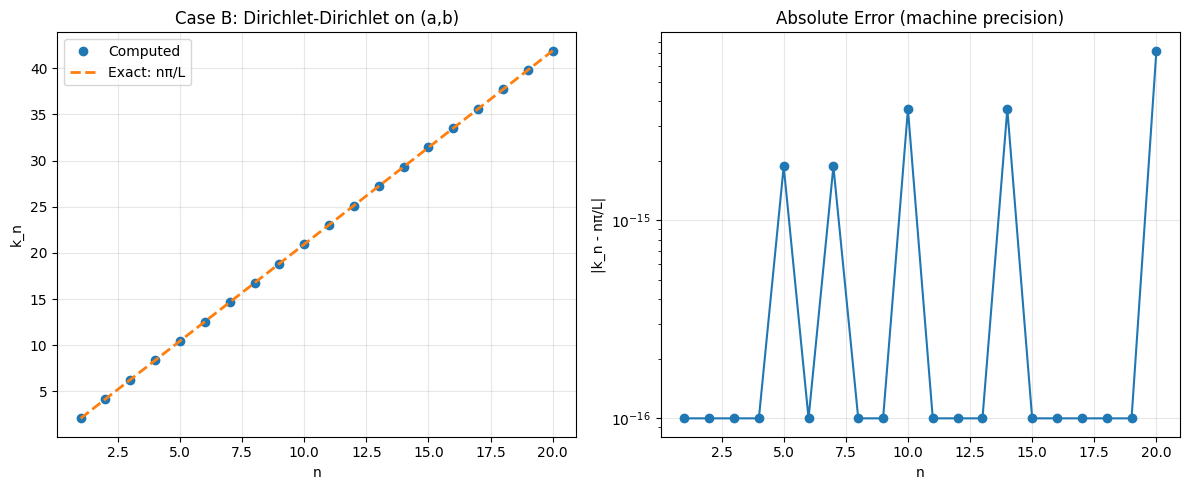

Max absolute error: 7.11e-15
All errors < 1e-10: True


In [5]:
a, b = 0.5, 2.0
L = b - a
alpha = 0.1
eps = 1e-6

domain_B = IntervalDomain(a, b, boundary_type='closed')
M_B = Lebesgue(100, domain_B, basis=None, weight=lambda r: (r + eps)**2)
bcs_DD = BoundaryConditions.dirichlet()
L_DD = RadialLaplacian(M_B, bcs_DD, alpha, method='spectral', dofs=20, ell=0)

# Compute eigenvalues
n_eigs = 20
eigenvalues = [L_DD.get_eigenvalue(i) for i in range(n_eigs)]
k_n = np.sqrt(np.array(eigenvalues) / alpha)

# Exact formula
n = np.arange(1, n_eigs + 1)
k_exact = n * np.pi / L

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: k_n vs n
ax1.plot(n, k_n, 'o', label='Computed', markersize=6)
ax1.plot(n, k_exact, '--', label='Exact: nπ/L', linewidth=2)
ax1.set_xlabel('n')
ax1.set_ylabel('k_n')
ax1.set_title('Case B: Dirichlet-Dirichlet on (a,b)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Absolute error
abs_error = np.abs(k_n - k_exact)
ax2.semilogy(n, abs_error + 1e-16, 'o-', markersize=6)  # Add small value to avoid log(0)
ax2.set_xlabel('n')
ax2.set_ylabel('|k_n - nπ/L|')
ax2.set_title('Absolute Error (machine precision)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max absolute error: {abs_error.max():.2e}")
print(f"All errors < 1e-10: {np.all(abs_error < 1e-10)}")

## Case B: Domain (a, b) - Dirichlet-Neumann

Asymptotic: k_n → nπ/L for large n

INFO:pygeoinf.interval.radial_operators:RadialLaplacian initialized: method=spectral, dofs=20, ℓ=0, alpha=0.1


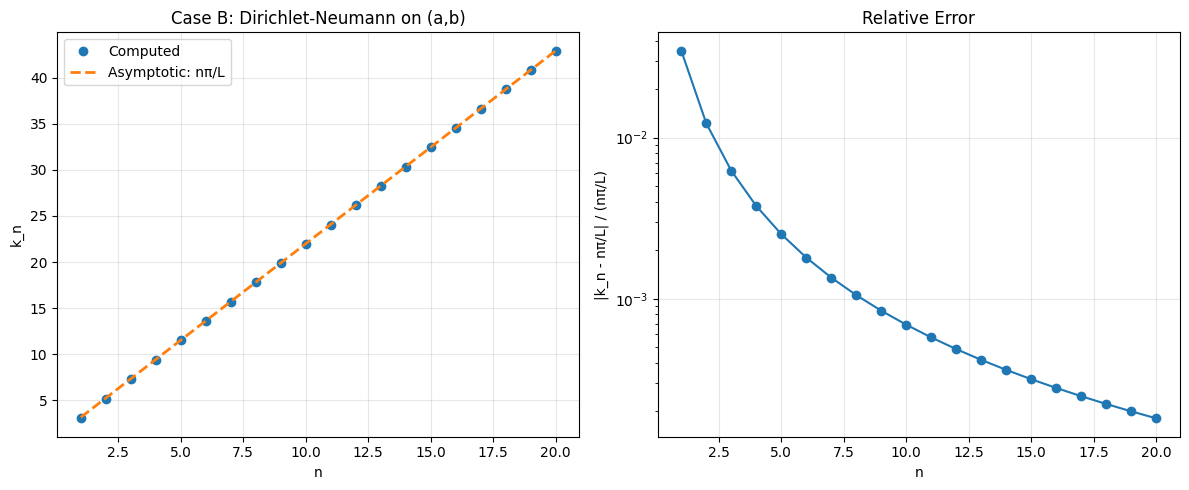

Max relative error: 3.47e-02
Relative error for n=20: 1.81e-04


In [10]:
a, b = 0.5, 2.0
L = b - a
alpha = 0.1
eps = 1e-6

domain_B = IntervalDomain(a, b, boundary_type='closed')
M_B = Lebesgue(100, domain_B, basis=None, weight=lambda r: (r + eps)**2)
bcs_DN = BoundaryConditions.mixed_dirichlet_neumann()
L_DN = RadialLaplacian(M_B, bcs_DN, alpha, method='spectral', dofs=20, ell=0)

# Compute eigenvalues
n_eigs = 20
eigenvalues = [L_DN.get_eigenvalue(i) for i in range(n_eigs)]
k_n = np.sqrt(np.array(eigenvalues) / alpha)

# Asymptotic formula
n = np.arange(1, n_eigs + 1)
k_asymptotic = (n+1/2) * np.pi / L

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: k_n vs n
ax1.plot(n, k_n, 'o', label='Computed', markersize=6)
ax1.plot(n, k_asymptotic, '--', label='Asymptotic: nπ/L', linewidth=2)
ax1.set_xlabel('n')
ax1.set_ylabel('k_n')
ax1.set_title('Case B: Dirichlet-Neumann on (a,b)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative error
rel_error = np.abs(k_n - k_asymptotic) / k_asymptotic
ax2.semilogy(n, rel_error, 'o-', markersize=6)
ax2.set_xlabel('n')
ax2.set_ylabel('|k_n - nπ/L| / (nπ/L)')
ax2.set_title('Relative Error')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max relative error: {rel_error.max():.2e}")
print(f"Relative error for n=20: {rel_error[-1]:.2e}")

## Case B: Domain (a, b) - Neumann-Dirichlet

Asymptotic: k_n → nπ/L for large n

INFO:pygeoinf.interval.radial_operators:RadialLaplacian initialized: method=spectral, dofs=20, ℓ=0, alpha=0.1


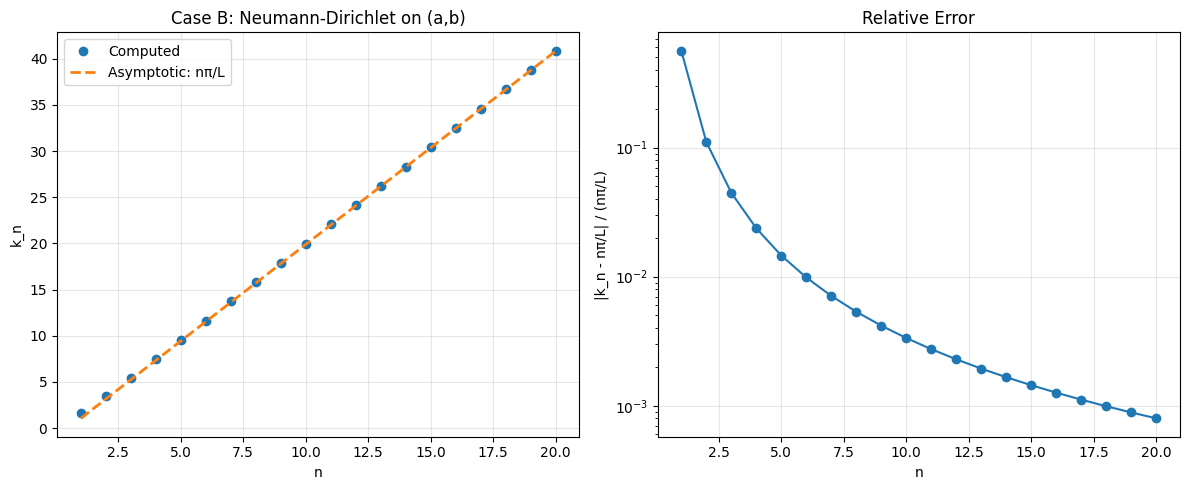

Max relative error: 5.63e-01
Relative error for n=20: 7.98e-04


In [9]:
a, b = 0.5, 2.0
L = b - a
alpha = 0.1
eps = 1e-6

domain_B = IntervalDomain(a, b, boundary_type='closed')
M_B = Lebesgue(100, domain_B, basis=None, weight=lambda r: (r + eps)**2)
bcs_ND = BoundaryConditions.mixed_neumann_dirichlet()
L_ND = RadialLaplacian(M_B, bcs_ND, alpha, method='spectral', dofs=20, ell=0)

# Compute eigenvalues
n_eigs = 20
eigenvalues = [L_ND.get_eigenvalue(i) for i in range(n_eigs)]
k_n = np.sqrt(np.array(eigenvalues) / alpha)

# Asymptotic formula
n = np.arange(1, n_eigs + 1)
k_asymptotic = (n-1/2) * np.pi / L

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: k_n vs n
ax1.plot(n, k_n, 'o', label='Computed', markersize=6)
ax1.plot(n, k_asymptotic, '--', label='Asymptotic: nπ/L', linewidth=2)
ax1.set_xlabel('n')
ax1.set_ylabel('k_n')
ax1.set_title('Case B: Neumann-Dirichlet on (a,b)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative error
rel_error = np.abs(k_n - k_asymptotic) / k_asymptotic
ax2.semilogy(n, rel_error, 'o-', markersize=6)
ax2.set_xlabel('n')
ax2.set_ylabel('|k_n - nπ/L| / (nπ/L)')
ax2.set_title('Relative Error')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max relative error: {rel_error.max():.2e}")
print(f"Relative error for n=20: {rel_error[-1]:.2e}")

## Case B: Domain (a, b) - Neumann-Neumann

Asymptotic: k_n → nπ/L for large n (note: k_0 = 0 for constant eigenfunction)

INFO:pygeoinf.interval.radial_operators:RadialLaplacian initialized: method=spectral, dofs=21, ℓ=0, alpha=0.1


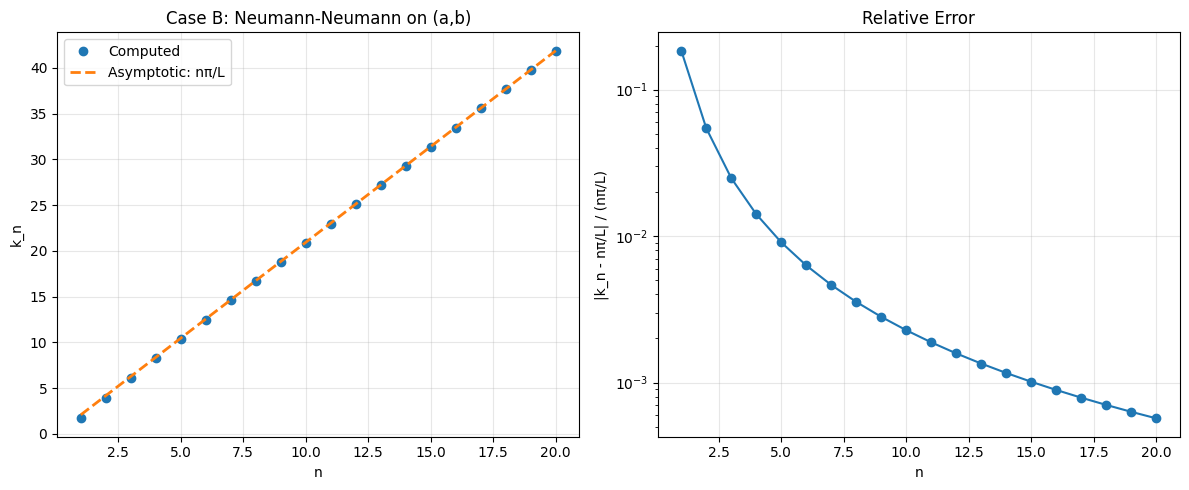

Max relative error: 1.84e-01
Relative error for n=20: 5.70e-04


In [8]:
a, b = 0.5, 2.0
L = b - a
alpha = 0.1
eps = 1e-6

domain_B = IntervalDomain(a, b, boundary_type='closed')
M_B = Lebesgue(100, domain_B, basis=None, weight=lambda r: (r + eps)**2)
bcs_NN = BoundaryConditions.neumann()
L_NN = RadialLaplacian(M_B, bcs_NN, alpha, method='spectral', dofs=21, ell=0)

# Compute eigenvalues (skip k_0 = 0)
n_eigs = 20
eigenvalues = [L_NN.get_eigenvalue(i+1) for i in range(n_eigs)]  # Start from index 1
k_n = np.sqrt(np.array(eigenvalues) / alpha)

# Asymptotic formula
n = np.arange(1, n_eigs + 1)
k_asymptotic = n * np.pi / L

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: k_n vs n
ax1.plot(n, k_n, 'o', label='Computed', markersize=6)
ax1.plot(n, k_asymptotic, '--', label='Asymptotic: nπ/L', linewidth=2)
ax1.set_xlabel('n')
ax1.set_ylabel('k_n')
ax1.set_title('Case B: Neumann-Neumann on (a,b)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative error
rel_error = np.abs(k_n - k_asymptotic) / k_asymptotic
ax2.semilogy(n, rel_error, 'o-', markersize=6)
ax2.set_xlabel('n')
ax2.set_ylabel('|k_n - nπ/L| / (nπ/L)')
ax2.set_title('Relative Error')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max relative error: {rel_error.max():.2e}")
print(f"Relative error for n=20: {rel_error[-1]:.2e}")